## Data Preprocessing
### Importing important libraries


In [14]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

### Data Preparation for analysing the whatsapp group chat
Tokenizing into {Date}{Time}-{Author}:{Message} format

In [15]:

def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [16]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [17]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message

In [18]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [19]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [20]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/akashverma/Downloads/WhatsApp Chat with GRM @ANZ (2).txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

19/06/17, 18:43 - AKASH ANZ created group "GRM @ANZ"



In [21]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

### Observing the data frame created from the .txt file

In [ ]:
#Doing the de-personalisation

In [22]:
df['Author']=df['Author'].replace([<original names>],['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12'])
df.Author.unique()

array(['P9', 'P12', 'P10', 'P7', 'P3', 'P2', 'P8', 'P1', 'P11', 'P6',
       'P5', 'P4'], dtype=object)

In [74]:
df.head(3)

Date   Time Author             Message    emoji  urlcount
0 2017-01-09  07:48     P9                 🏃🏻🕰  [🏃🏻, 🕰]         0
1 2017-01-09  07:53    P12                 🏃🏻☠  [🏃🏻, ☠]         0
2 2017-01-09  07:54     P9   Terribly late ? 😜      [😜]         0

### Examining the number of unique participants in the chat group

In [29]:
df.Author.unique()

array(['P9', 'P12', 'P10', 'P7', 'P3', 'P2', 'P8', 'P1', 'P11', 'P6',
       'P5', 'P4'], dtype=object)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29820 entries, 0 to 30534
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      29820 non-null  datetime64[ns]
 1   Time      29820 non-null  object        
 2   Author    29820 non-null  object        
 3   Message   29820 non-null  object        
 4   emoji     29820 non-null  object        
 5   urlcount  29820 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.6+ MB


### Total Messages exchanged in the group

In [31]:
total_messages = df.shape[0]
print(total_messages)

29820


In [32]:
df.shape

(29820, 6)

In [33]:
media_messages = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')].shape[0]

### Total Emojis exchanged

In [34]:
emojis = sum(df['emoji'].str.len())
print(emojis)

11878


In [35]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [36]:
links = np.sum(df.urlcount)

### Overall Group Stats

In [37]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 29820
Media: 2067
Emojis: 11878
Links: 45


### Creating different data frames from the base file

In [38]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")|(df["Message"] == " You deleted this message.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [39]:
deleted_messages_num = deleted_messages.shape[0]
deleted_messages_num
media_messages_df.shape

(2067, 6)

In [40]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27675 entries, 0 to 30534
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      27675 non-null  datetime64[ns]
 1   Time      27675 non-null  object        
 2   Author    27675 non-null  object        
 3   Message   27675 non-null  object        
 4   emoji     27675 non-null  object        
 5   urlcount  27675 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.5+ MB


In [41]:
media_messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 23 to 30528
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2067 non-null   datetime64[ns]
 1   Time      2067 non-null   object        
 2   Author    2067 non-null   object        
 3   Message   2067 non-null   object        
 4   emoji     2067 non-null   object        
 5   urlcount  2067 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 113.0+ KB


In [42]:

messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [43]:
messages_df.head(2)

Date   Time Author Message    emoji  urlcount  Letter_Count  \
0 2017-01-09  07:48     P9     🏃🏻🕰  [🏃🏻, 🕰]         0             4   
1 2017-01-09  07:53    P12     🏃🏻☠  [🏃🏻, ☠]         0             4   

   Word_Count  MessageCount  
0           2             1  
1           2             1

In [44]:
messages_df["emojicount"]= df['emoji'].str.len()

In [47]:
media_messages_df.head()


Date   Time Author           Message emoji  urlcount
23 2017-01-09  22:05    P10   <Media omitted>    []         0
31 2017-02-09  18:37     P7   <Media omitted>    []         0
33 2017-02-09  19:07     P9   <Media omitted>    []         0
41 2017-05-09  23:28     P8   <Media omitted>    []         0
58 2017-07-09  16:55    P10   <Media omitted>    []         0

### Creating data frames for doing the summary statistics

In [48]:
df1=messages_df.groupby("Author")["MessageCount"].count().to_frame(name='Total Messages Sent').reset_index()
df2=messages_df.groupby("Author")["Word_Count"].sum().to_frame(name='Total Words').reset_index()
df3=media_messages_df.groupby("Author")["Author"].count().to_frame(name='Media Messages').reset_index()
df4=messages_df.groupby("Author")["emojicount"].sum().to_frame(name='Total Emojis Sent').reset_index()
df5=link_messages.groupby("Author")["Author"].count().to_frame(name='Total Links Sent').reset_index()

In [49]:
dfs=[df1,df2,df3,df4]
from functools import reduce
df_summary = reduce(lambda left,right: pd.merge(left,right,on='Author'), dfs)
df_summary["Avg words per message"]=df_summary["Total Words"]/df_summary["Total Messages Sent"]
del df_summary["Total Words"]
df_summary=df_summary.sort_values('Total Messages Sent',ascending=False).reset_index()
del df_summary["index"]
df_summary

Author  Total Messages Sent  Media Messages  Total Emojis Sent  \
0     P12                 5547             529               1385   
1      P9                 4048             215               2561   
2      P7                 3554             375               2382   
3     P10                 3540             396               1985   
4      P1                 3416             221                302   
5      P8                 3219             102               1699   
6     P11                 2087              62                613   
7      P3                  896              83                566   
8      P2                  484              19                 55   
9      P4                  365              53                129   
10     P6                  344               6                123   
11     P5                  175               6                 73   

    Avg words per message  
0                6.987741  
1                6.876235  
2                9.191052  
3                7.211017  
4                6.156323  
5                6.085120  
6                8.390992  
7                5.380580  
8                6.747934  
9                5.821918  
10               6.662791  
11               6.314286

## Since we all love Emojis :)

### Emoji insights

In [50]:

total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

298


In [51]:

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('🤣', 2144), ('😂', 2116), ('😜', 830), ('😛', 688), ('😝', 634), ('😅', 612), ('🙈', 403), ('😬', 248), ('🤪', 211), ('😀', 210), ('🙄', 160), ('😃', 139), ('😳', 117), ('🤔', 114), ('😐', 107), ('😏', 101), ('🤭', 98), ('😋', 77), ('🤦\u200d♂️', 72), ('😎', 71), ('😁', 69), ('😶', 64), ('🤦🏻\u200d♀️', 59), ('🙊', 55), ('🤓', 54), ('😑', 53), ('👍', 53), ('👻', 53), ('😊', 52), ('🙁', 51), ('🤨', 51), ('😕', 50), ('🥺', 50), ('😭', 49), ('🥳', 44), ('🎉', 42), ('😢', 40), ('👆', 39), ('🤦🏼\u200d♂️', 38), ('😍', 37), ('👏', 36), ('🤦🏼\u200d♂', 35), ('🤦\u200d♂', 35), ('🤩', 35), ('☹', 34), ('😮', 33), ('👍🏼', 33), ('🙏', 33), ('👏🏻', 33), ('😒', 31), ('😉', 30), ('😄', 30), ('😆', 28), ('🎂', 28), ('😱', 27), ('😓', 26), ('🤘', 24), ('👌', 23), ('😯', 23), ('😇', 23), ('🕰', 22), ('😘', 22), ('🍻', 22), ('🏃🏻', 21), ('👆🏼', 21), ('🙌🏻', 21), ('👏🏼', 20), ('😣', 19), ('🧐', 19), ('😞', 18), ('😠', 18), ('👆🏻', 17), ('🙌🏼', 17), ('🙀', 17), ('✌🏻', 17), ('🤷🏼\u200d♂', 16), ('👍🏻', 16), ('😖', 16), ('☹️', 16), ('🙂', 15), ('🙏🏻', 14), ('🤷🏼\u200d♂️', 14), ('🤗', 13)

In [52]:

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

emoji  count
0       🤣   2144
1       😂   2116
2       😜    830
3       😛    688
4       😝    634
..    ...    ...
293     🍼      1
294     ❓      1
295    🧔🏻      1
296     💎      1
297     ❌      1

[298 rows x 2 columns]

In [53]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [54]:
# Creates a list of unique Authors - ['P1','P2' .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for P9


Emoji Distribution for P12


Emoji Distribution for P10


Emoji Distribution for P7


Emoji Distribution for P3


Emoji Distribution for P2


Emoji Distribution for P1


Emoji Distribution for P8


Emoji Distribution for P11


Emoji Distribution for P6


Emoji Distribution for P5


Emoji Distribution for P4


### Activity Analysis

In [55]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [56]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()


### Lockdown effect

In [57]:

date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [58]:

date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

In [59]:

auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

Text(0, 0.5, 'Time')

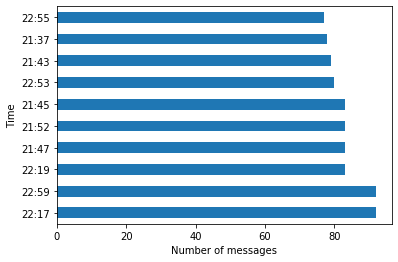

In [60]:

messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

2020-02-06    543
2020-03-06    410
2020-04-30    406
2020-03-24    387
2020-12-06    351
             ... 
2017-10-21      1
2018-04-28      1
2019-04-28      1
2019-08-07      1
2019-12-17      1
Name: Date, Length: 729, dtype: int64


Text(0, 0.5, 'Date')

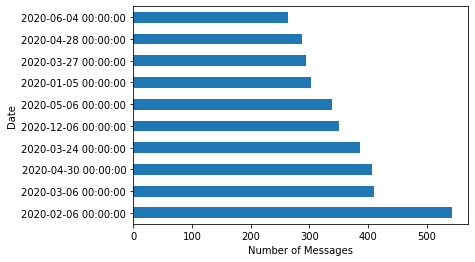

In [61]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### Word Cloud

In [62]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2017-09-25 00:00:00
Time                                                        19:31
Author                                                        P12
Message          गिलक्रिस्ट और हेडेन का दिल दहलाने वाला कहर क्...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                 2259
Word_Count                                                    491
MessageCount                                                    1
emojicount                                                      0
Name: 501, dtype: object

In [63]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 904481 words in all the messages.


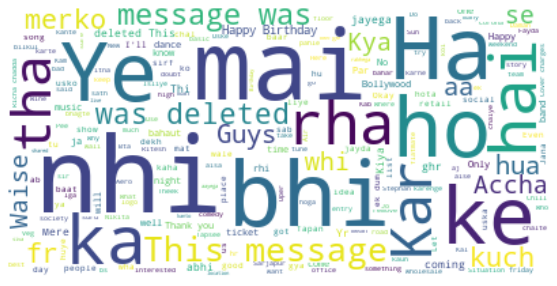

In [66]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name P9


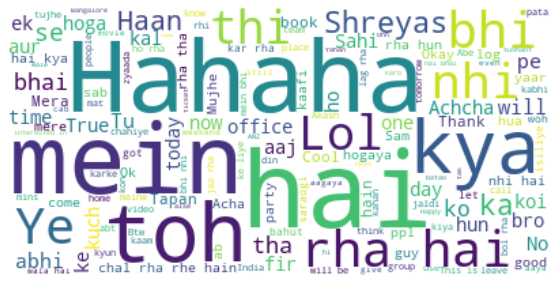

Author name P12


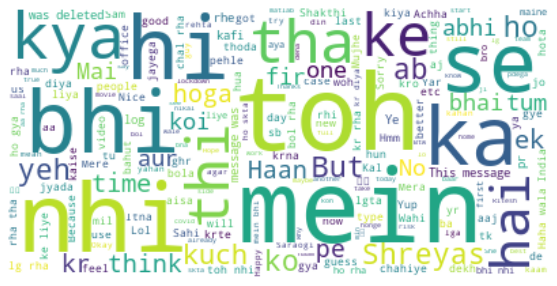

Author name P10


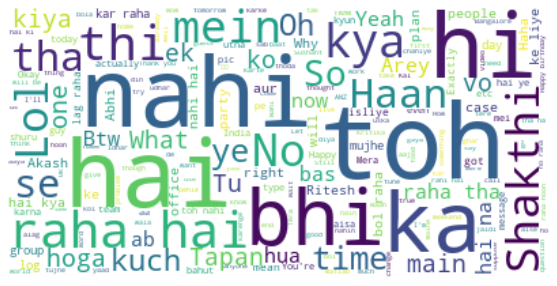

Author name P7


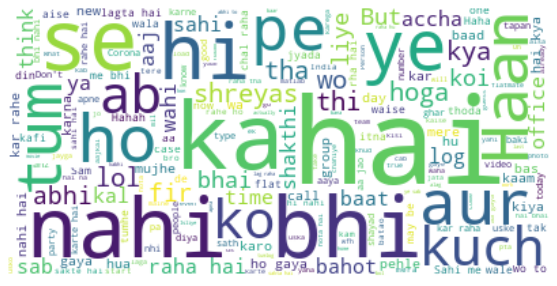

Author name P3


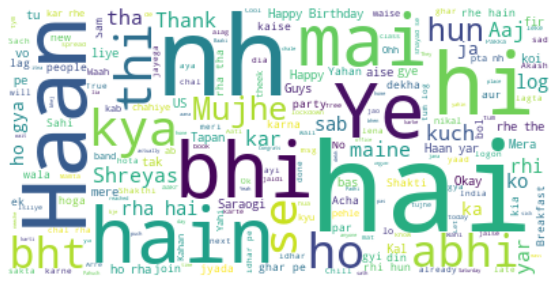

Author name P2


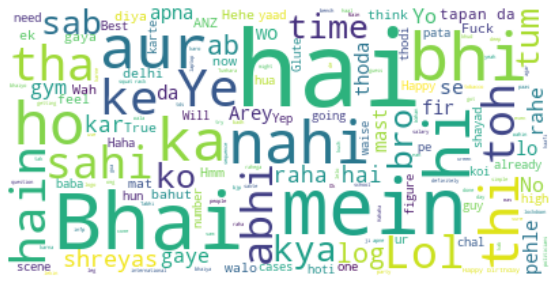

Author name P1


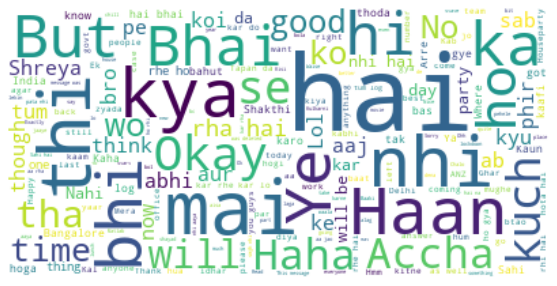

Author name P8


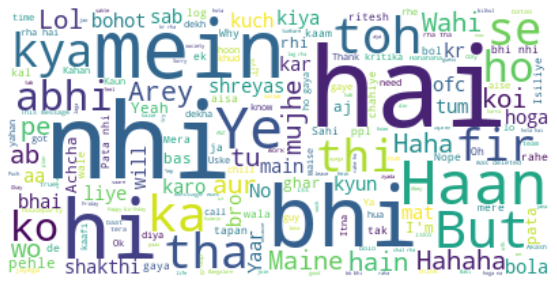

Author name P11


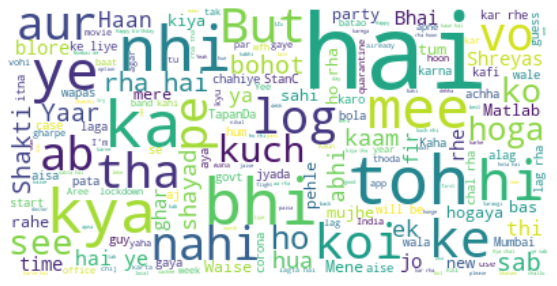

Author name P6


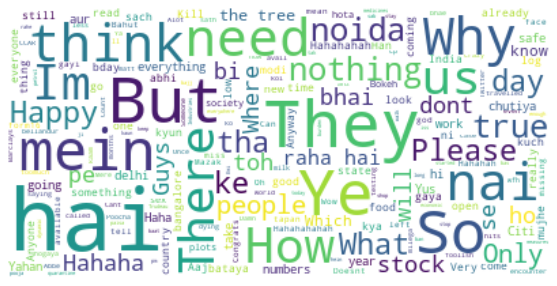

Author name P5


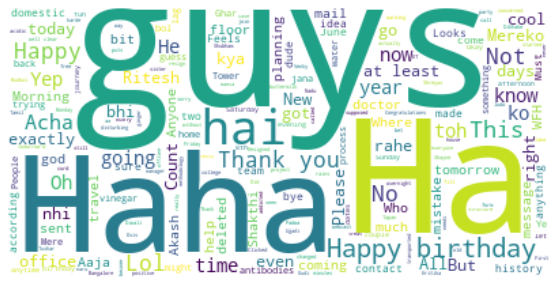

Author name P4


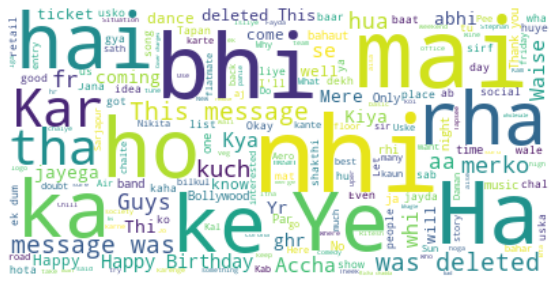

In [65]:
 l = messages_df.Author.unique()
 for i in range(len(l)):
   dummy_df = messages_df[messages_df['Author'] == l[i]]
   text = " ".join(review for review in dummy_df.Message)
   stopwords = set(STOPWORDS)
   stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
   # Generate a word cloud image
   print('Author name',l[i])
   wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
   # Display the generated image:
   # the matplotlib way:
  
   plt.figure( figsize=(10,5))
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()